In [303]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import math
from datetime import datetime
from sklearn import linear_model

data = pd.read_csv("owid-covid-data.csv") 

data = data[data.iso_code=="RUS"]
data = data[data.date >= '2020-03-03']
data.head(1000)

total = np.array(data.total_cases[0:50])

new = np.array(data.new_cases[0:50])
new = [x if x!=0 else 1 for x in new]


[    3     4     4     4    10    10    10    10    10    25    30    45
    59    63    93   114   147   199   253   306   438   438   495   658
   840  1036  1264  1534  1836  2337  2777  3548  4149  4731  5389  6343
  7497  8672 10131 11917 13584 15770 18328 21102 24490 27938 32008 36793
 42853 47121]


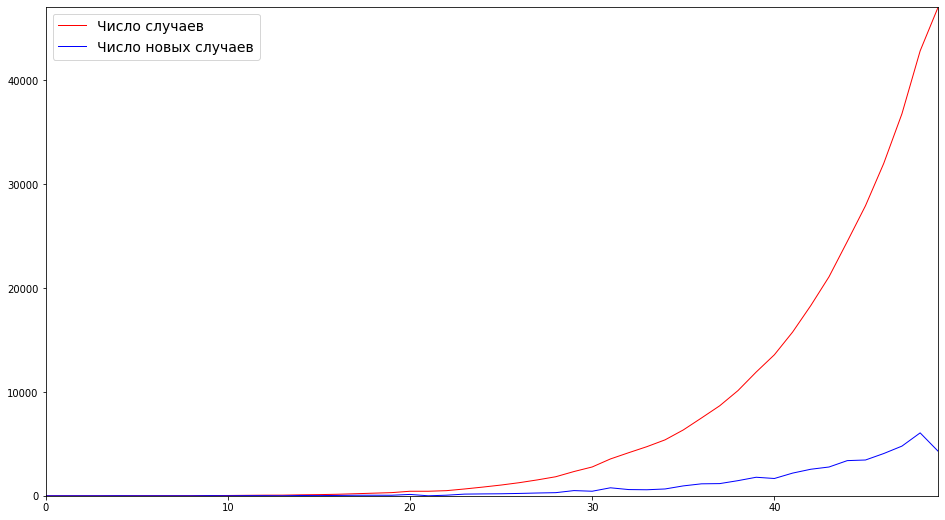

In [265]:
days = np.linspace(0,49,50)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.set_xlim((days[0], days[-1]))
ax.set_ylim((0, total[-1]))

ax.plot(days, total, linewidth=1, label="Число случаев", color="red")
ax.plot(days, new, linewidth=1, label="Число новых случаев", color="blue")

ax.legend(loc="upper left", fontsize=14)

plt.show()

Будем исходить из априорного распределения параметров y = exp{w0*x + w1} из N(0, a*I). Найдем параметры нормального апостериорного распределения p(w|D)

In [266]:
def create_X_matrix(n):
    t = range(0,2*n)
    t = np.array([ x/2 if x%2==0 else 1 for x in t])
    t= t.reshape(n,2)
    return t

In [267]:
import math

def param_function(a,b,d,N,X,y):
    A = b* (X.transpose()).dot(X) + np.eye(d) * a
    #print(A)
    m = b * np.linalg.inv(A).dot(X.transpose().dot(y))
    #print(m)
    return  .5 * d * math.log(a) \
            + .5*N * math.log(b) \
            - 0.5 * b * np.linalg.norm(y- X.dot(m)) ** 2  \
            - 0.5 * a * np.linalg.norm(m)**2 \
            - 0.5 * math.log(np.linalg.det(A)) 

Оптимизируем параметры a и b исходя из dataset числа заболевших

In [268]:
X = create_X_matrix(50)
total_exp = np.array([math.log(t) for t in total])

param_function(1,1,2,50,X,total_exp)

result = -1000000
for x in np.linspace(0.1,50,300):
    for y in np.linspace(0.1,50,300):
        new_result = param_function(x,y,2,50,X,total_exp)
        if new_result>result:
            best_a = x
            best_b = y
            result = new_result

print (best_a, best_b, result)


0.934448160535117 7.443143812709029 16.52761391495929


Найтем математическое ожидание апостериорного распредерения, для этого надо использовать регрессию Лассо с регуляризатором a/b

In [269]:
from sklearn import linear_model

model = linear_model.Ridge(alpha = best_a/best_b, fit_intercept=False).fit(X, total_exp)

print("Среднее апостериорного распределения", model.coef_)

Среднее апостериорного распределения [0.2037106 1.4647382]


In [270]:
std_dev = math.sqrt(1/(best_a + best_b))
print("Стандартное отклонение апостериорного распределения:", std_dev)

Стандартное отклонение апостериорного распределения: 0.34549391102679233


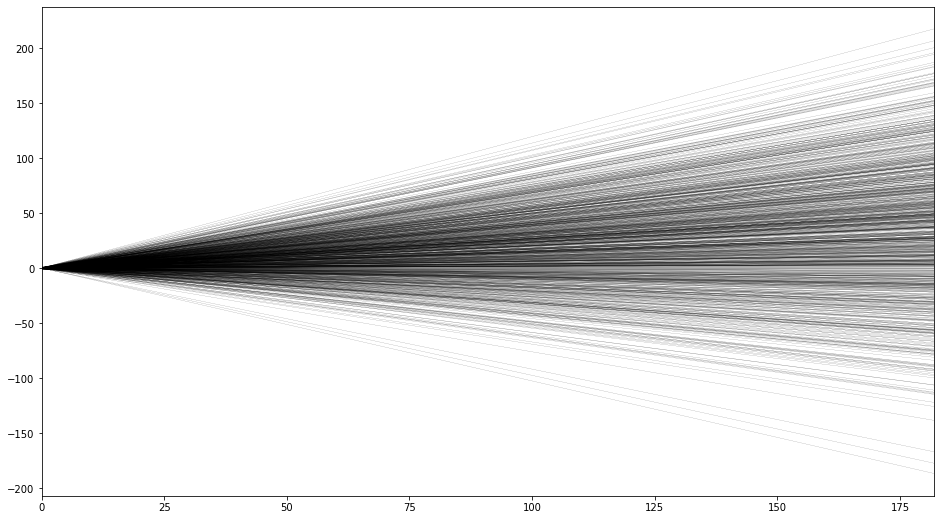

In [271]:
from scipy.stats import multivariate_normal
import datetime

mean = [model.coef_[0], model.intercept_]

def get_sample(mean, std_dev, n):
     return multivariate_normal.rvs(mean=mean, cov=np.eye(n)*std_dev**2)

days = np.linspace(0,100,101)


start = datetime.date(2020,3,3)
may_1 = (datetime.date(2020,5,1) - start).days
jun_1 = (datetime.date(2020,6,1) - start).days 
sep_1 = (datetime.date(2020,9,1) - start).days 

may1_arr = []
jun1_arr = []
sep1_arr = []

days = np.linspace(0,sep_1,sep_1+1)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.set_xlim((days[0], days[-1]))

for i in range(0,1000):
    sample = get_sample(mean, std_dev,2)
    generated = [x*sample[0]+sample[1] for x in days]    
    ax.plot(days, generated, linewidth=.1, color="black")
    may1_arr.append(generated[may_1])
    jun1_arr.append(generated[jun_1])
    sep1_arr.append(generated[sep_1])
    
plt.show()


(array([  2.,   1.,   1.,   2.,   7.,  15.,  21.,  35.,  43.,  55.,  85.,
        105., 106., 105., 100.,  83.,  75.,  51.,  45.,  28.,  15.,  13.,
          5.,   2.]),
 array([-60.51925319, -55.05418447, -49.58911575, -44.12404703,
        -38.65897831, -33.19390959, -27.72884087, -22.26377215,
        -16.79870343, -11.3336347 ,  -5.86856598,  -0.40349726,
          5.06157146,  10.52664018,  15.9917089 ,  21.45677762,
         26.92184634,  32.38691506,  37.85198378,  43.31705251,
         48.78212123,  54.24718995,  59.71225867,  65.17732739,
         70.64239611]),
 <a list of 24 Patch objects>)

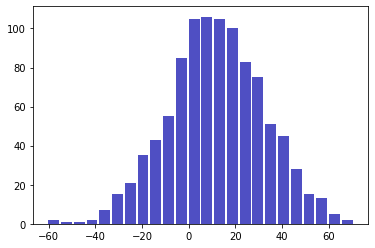

In [272]:
plt.hist(x=may1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 мая')

(array([  2.,   1.,   1.,   2.,   7.,  10.,  21.,  24.,  38.,  56.,  73.,
         88.,  92., 102., 109.,  86.,  79.,  69.,  40.,  46.,  23.,  14.,
         10.,   5.,   2.]),
 array([-92.3849331 , -84.38020118, -76.37546926, -68.37073734,
        -60.36600542, -52.3612735 , -44.35654158, -36.35180966,
        -28.34707774, -20.34234581, -12.33761389,  -4.33288197,
          3.67184995,  11.67658187,  19.68131379,  27.68604571,
         35.69077763,  43.69550955,  51.70024147,  59.70497339,
         67.70970531,  75.71443723,  83.71916915,  91.72390108,
         99.728633  , 107.73336492]),
 <a list of 25 Patch objects>)

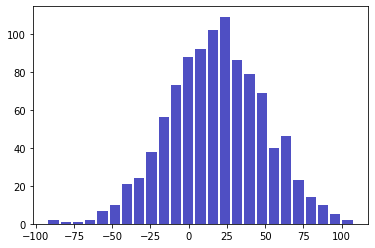

In [273]:
plt.hist(x=jun1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 июня')

(array([  2.,   1.,   1.,   2.,   7.,  10.,  20.,  25.,  39.,  55.,  71.,
         87.,  94., 103., 110.,  86.,  78.,  69.,  40.,  46.,  24.,  14.,
         10.,   4.,   2.]),
 array([-186.95404767, -170.76349422, -154.57294078, -138.38238733,
        -122.19183389, -106.00128044,  -89.81072699,  -73.62017355,
         -57.4296201 ,  -41.23906666,  -25.04851321,   -8.85795977,
           7.33259368,   23.52314713,   39.71370057,   55.90425402,
          72.09480746,   88.28536091,  104.47591435,  120.6664678 ,
         136.85702124,  153.04757469,  169.23812814,  185.42868158,
         201.61923503,  217.80978847]),
 <a list of 25 Patch objects>)

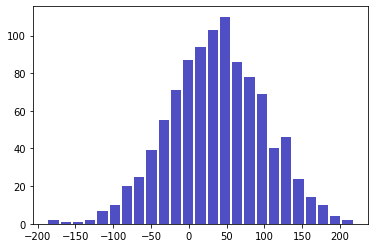

In [274]:
plt.hist(x=sep1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм числа заболевших к 1 сентября')

Сделаем то же самое для new_cases

In [275]:
X = create_X_matrix(50)
new_exp = np.array([math.log(t) for t in new])

result = -1000000
for x in np.linspace(0.1,50,300):
    for y in np.linspace(0.1,50,300):
        new_result = param_function(x,y,2,50,X,new_exp)
        if new_result>result:
            best_a = x
            best_b = y
            result = new_result

print (best_a, best_b, result)

36.81571906354515 1.4351170568561873 -20.28557221197176


In [276]:
model = linear_model.Ridge(alpha = best_a/best_b, fit_intercept=False).fit(X, new_exp)

mean = model.coef_
print("Среднее апостериорного распределения", mean)
std_dev = math.sqrt(1/(best_a + best_b))
print("Стандартное отклонение апостериорного распределения:", std_dev)

Среднее апостериорного распределения [ 0.18959038 -0.017758  ]
Стандартное отклонение апостериорного распределения: 0.16168864949559822


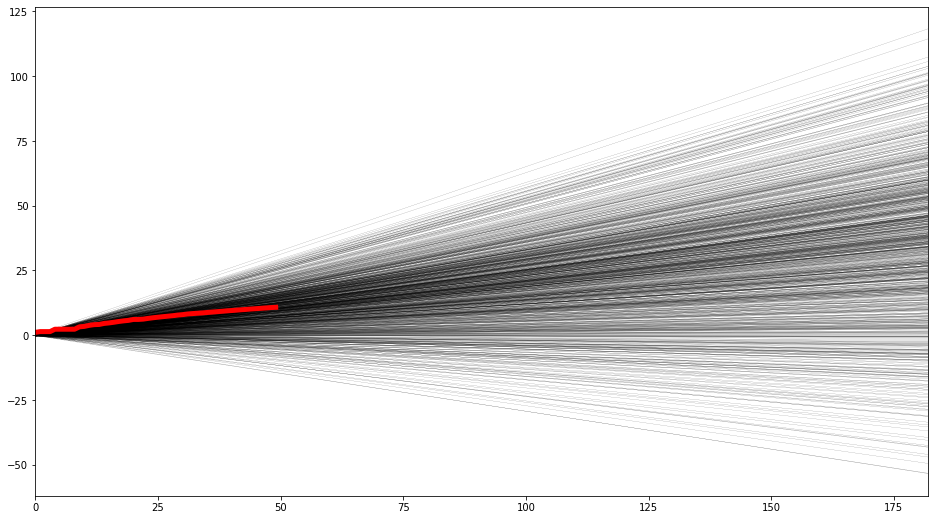

In [278]:
days = np.linspace(0,100,101)

may1_arr = []
jun1_arr = []
sep1_arr = []

days = np.linspace(0,sep_1,sep_1+1)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.set_xlim((days[0], days[-1]))



for i in range(0,1000):
    sample = get_sample(mean, std_dev,2)
    generated = [x*sample[0]+sample[1] for x in days]    
    ax.plot(days, generated, linewidth=.1, color="black")
    may1_arr.append(generated[may_1])
    jun1_arr.append(generated[jun_1])
    sep1_arr.append(generated[sep_1])
    
    
ax.plot(range(0,50), total_exp, linewidth=5, color="red")
plt.show()

(array([  5.,   5.,   6.,  13.,  16.,  27.,  46.,  63.,  56.,  76.,  96.,
         91., 108., 105.,  92.,  59.,  47.,  31.,  20.,  18.,  15.,   3.,
          2.]),
 array([-17.39639186, -14.96822902, -12.54006618, -10.11190334,
         -7.6837405 ,  -5.25557766,  -2.82741482,  -0.39925198,
          2.02891086,   4.4570737 ,   6.88523654,   9.31339938,
         11.74156222,  14.16972506,  16.5978879 ,  19.02605074,
         21.45421358,  23.88237642,  26.31053926,  28.7387021 ,
         31.16686494,  33.59502778,  36.02319062,  38.45135346]),
 <a list of 23 Patch objects>)

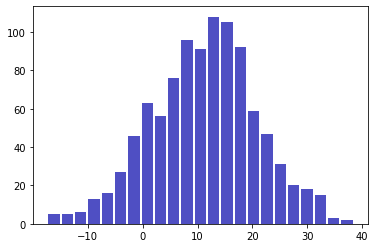

In [279]:
plt.hist(x=may1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 мая')

(array([  5.,   5.,   6.,  13.,  16.,  27.,  46.,  63.,  56.,  74.,  97.,
         92., 107., 104.,  94.,  56.,  50.,  31.,  19.,  17.,  16.,   4.,
          2.]),
 array([-26.44881214, -22.75218251, -19.05555288, -15.35892324,
        -11.66229361,  -7.96566398,  -4.26903435,  -0.57240471,
          3.12422492,   6.82085455,  10.51748418,  14.21411382,
         17.91074345,  21.60737308,  25.30400271,  29.00063235,
         32.69726198,  36.39389161,  40.09052124,  43.78715087,
         47.48378051,  51.18041014,  54.87703977,  58.5736694 ]),
 <a list of 23 Patch objects>)

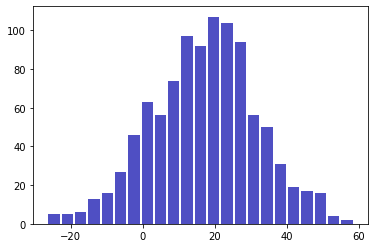

In [280]:
plt.hist(x=jun1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 июня')

(array([  5.,   5.,   7.,  12.,  17.,  29.,  43.,  63.,  56.,  74.,  95.,
         95., 106., 102.,  95.,  59.,  46.,  31.,  20.,  18.,  16.,   4.,
          2.]),
 array([-53.42437312, -45.95846514, -38.49255717, -31.0266492 ,
        -23.56074123, -16.09483325,  -8.62892528,  -1.16301731,
          6.30289067,  13.76879864,  21.23470661,  28.70061458,
         36.16652256,  43.63243053,  51.0983385 ,  58.56424648,
         66.03015445,  73.49606242,  80.96197039,  88.42787837,
         95.89378634, 103.35969431, 110.82560229, 118.29151026]),
 <a list of 23 Patch objects>)

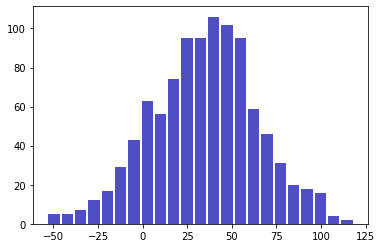

In [281]:
plt.hist(x=sep1_arr, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Логарифм новых заболевших 1 сентября')

## 3.

 Для подбора сигмоиды перейдем от total_cases к new_cases, возьмем логорифм и будем приближать полученные значения регрессией. Действовать будем по аналогии с предыдущим пунктом

In [282]:
x0 = [1 for _ in range(0,50)]
x1 = [i for i in range(0,50)]
x2 = [i*i for i in range(0,50)]

X = np.vstack([x0,x1,x2]).transpose()
#print(X)

result = -1000000
for x in np.linspace(0.1,50,300):
    for y in np.linspace(0.1,50,300):
        new_result = param_function(x,y,3,50,X,new_exp)
        if new_result>result:
            best_a = x
            best_b = y
            result = new_result

print (best_a, best_b, result)

38.65150501672241 1.4351170568561873 -25.1955643343299


[0.         0.         0.         0.         1.79175947 0.
 0.         0.         0.         2.7080502  1.60943791 2.7080502
 2.63905733 1.38629436 3.40119738 3.04452244 3.49650756 3.95124372
 3.98898405 3.97029191 4.88280192 0.         4.04305127 5.0937502
 5.20400669 5.27811466 5.42934563 5.59842196 5.71042702 6.2166061
 6.08677473 6.64768837 6.39859493 6.36647045 6.48920493 6.86066367
 7.05098945 7.06902343 7.28550655 7.48773376 7.41878088 7.68982867
 7.84698098 7.9280456  8.12799506 8.14554963 8.31139828 8.4732413
 8.70946508 8.35890061]
Среднее апостериорного распределения [-0.09781892  0.21580772 -0.00064154]
Стандартное отклонение апостериорного распределения: 0.15794295866242705


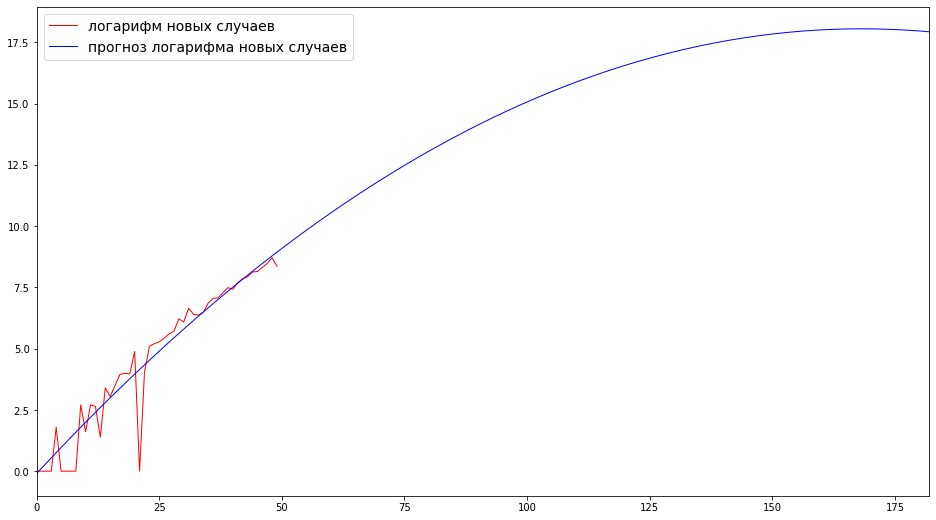

In [283]:
print(new_exp)

model = linear_model.Ridge(alpha = best_a/best_b, fit_intercept = False).fit(X, new_exp)
mean = model.coef_
print("Среднее апостериорного распределения", mean)
std_dev = math.sqrt(1/(best_a + best_b))
print("Стандартное отклонение апостериорного распределения:", std_dev)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.set_xlim((days[0], days[-1]))
forecast = [mean[0] + mean[1]*x + mean[2]*x**2 for x in days]

ax.plot(range(0,50), new_exp, linewidth=1, label="логарифм новых случаев", color="red")
ax.plot(days, forecast, linewidth=1, label="прогноз логарифма новых случаев", color="blue")

ax.legend(loc="upper left", fontsize=14)

plt.show()

In [332]:
def get_total_cases(p_x0, p_x1, p_x2, day):
    p_x2 = -p_x2
    p_x1 = -p_x1
    p_x0 = -p_x0
    
    #print("x2:", p_x2,"x1:", p_x1, "x0", p_x0)
    #print("новых", p_x0 + p_x1*day + p_x2*day**2)
    # замена переменных   
    y = day * math.sqrt(2*p_x2) + p_x1 / math.sqrt(2*p_x2)
    
    #print(p_x2, p_x1, p_x0)
    #print("было стало",day,y)
    
    #print(sp.stats.norm.cdf(y) * math.sqrt(math.pi/p_x2))
    #print(math.exp(p_x0 - .25*p_x1**2/p_x2))
     
    return [math.sqrt(math.pi/p_x2) * math.exp(-p_x0 + .25*p_x1**2/p_x2), \
            sp.stats.norm.cdf(y) * math.sqrt(math.pi/p_x2) * math.exp(-p_x0 + .25*p_x1**2/p_x2)]

In [325]:
days = np.linspace(0,100,101)

print(mean)

total_cases = []

for i in range(0,1000):
    sample = get_sample([mean[0],mean[1]], std_dev,2)
    total_cases.append(math.log(get_total_cases(sample[0], sample[1], mean[2], x)))
    


[-0.09781892  0.21580772 -0.00064154]


оптимистичный сценарий: 178.446767758383 заболевших
пессимистичный сценарий: 1.9947963535555887e+32 заболевших


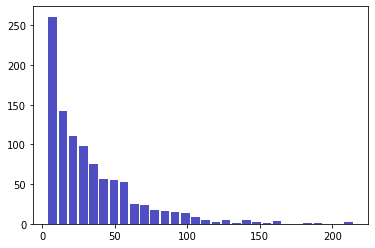

In [331]:
plt.hist(x=total_cases, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label ='Прогноз логарифма общего числа заболевших')

total_cases.sort()
print("оптимистичный сценарий:", math.exp(total_cases[100]),"заболевших")
print("пессимистичный сценарий:", math.exp(total_cases[900]),"заболевших")

## 5

In [ ]:
Довольно бессмысленно моделировать экспоненциальные ряды с помощью сигмоиды, пока распространение не начало замедляться, прогноз общего числа заболевших ничего не даст. Насчет карантина, если бы сигмоида отработала, 